# Quantitative Biology and Biophysics (AS.020.674/618)	Spring 2022
# Gordus Lab 
# March 04, 2022

#  Recursive Methods

Today we’re going to write a bootstrap algorithm to test whether two distributions are different, or not. We will also use a curve fitting algorithm that uses steepest descent to find the best-fit parameters for a protein binding curve.

## Libraries you will need

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# You need to initialize the random number generator
random.seed


<bound method Random.seed of <random.Random object at 0x7ff1e30baa18>>

## Load numpy data

You will need to load data from a 'npz' file. Please provide the path for where you saved the file, and load the data using the code below

In [2]:
file = 'lab_5_data.npz'

npzfile = np.load(file)

dwell_times_1 = npzfile['taus1']
dwell_times_2 = npzfile['taus2']
f_bound = npzfile['f']


# Bootstrapping

You have been provide the dwell times from two single molecule experiments ('taus1' and 'taus2').

**Do the following:**

1. For each dwell time array, make an integer array from 0 -> size(dwell_times_array) and call it 'P1' or 'P2'. Divide each array by N for each dwell_times array. For example, if a dwell_times array has 10 entries: `P = np.arange(0,np.size(dwell_times)) / np.size(dwell_times)`.

2. Sort each dwell_times array from highest to lowest: `dwell_times[::-1].sort()`

3. Now plot each P vs. dwell_times. This is the equivalent of plotting the cumulative distribution for P(t>T).


## Student Input Cell

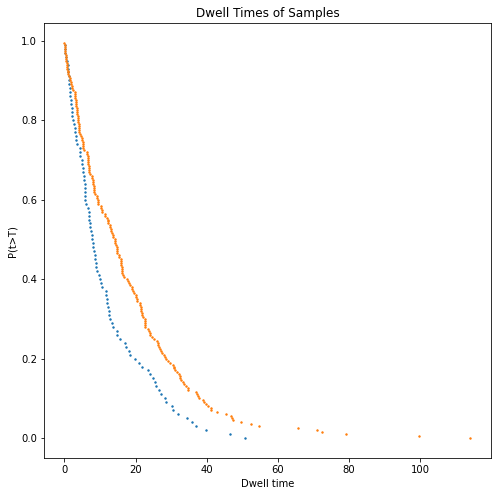

In [74]:
P1 = np.arange(0,np.size(dwell_times_1)) / np.size(dwell_times_1)
P2 = np.arange(0,np.size(dwell_times_2)) / np.size(dwell_times_2)

dwell_times_1[::-1].sort()
dwell_times_2[::-1].sort()

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(dwell_times_1, P1, s=2)
ax.scatter(dwell_times_2, P2, s=2)

ax.set_xlabel('Dwell time')
ax.set_ylabel('P(t>T)')
ax.set_title('Dwell Times of Samples')
plt.show()

These distributions (should) appear to be exponential, but with different decay constants. But are they really different? Let's test!

If we use a maximum likelihood approach, the tau (1 / rate constant) for each distribution should be:

<img src="http://www.gordus.org/public_images/tau.png" style="width: 600px;"/>

**Do the following:**

1. Calculate the tau for each distribution.
2. Calculate the ABSOLUTE difference between these taus. This will be the parameter we will test.

## Student Input Cell

In [37]:
tau_1 = dwell_times_1.mean()
tau_2 = dwell_times_2.mean()

tau_diff = abs(tau_1 - tau_2)
tau_diff

6.23070724297162

The null hypothesis is that both of these taus came from the same distribution, therefore the probability of observing the difference from above is very likely.

**To test this, do the following:**

1. Set a counter to 0. i.e. `counter = 0`.
2. Use `np.append()` to combine both dwell time arrays into 1 array.
3. Create an array of values chosen at random (with replacement) from the combined array of size (array 1).
4. Create a second array of values chosen at random (with replacement) from the combined array of size (array 2).
5. Calculate the tau values for each of these new dwell time distributions.
6. Calculate the ABSOLUTE difference between these taus.
7. If this difference is GREATER than the observed differene of the original data, increase the counter by 1.
8. Repeat steps 3 - 7 10,000 times.

**Useful tool**

If you want too create an array of size N that is randomly drawn (with replacement) from array X:

`random_elements_from_X = random.choices(X, k=N)`

## Student Input Cell

In [47]:
ITERS = 10000
counter = 0
combined = np.append(dwell_times_1, dwell_times_2)

for i in range(ITERS):
    temp1 = np.array(random.choices(combined, k=len(dwell_times_1)))
    temp2 = np.array(random.choices(combined, k=len(dwell_times_2)))
    
    tau_temp1 = temp1.mean()
    tau_temp2 = temp2.mean()
    
    tau_temp_diff = abs(tau_temp1 - tau_temp2)
    
    if tau_temp_diff > tau_diff:
        counter += 1

counter

19

**What is the probability the null hypothesis is correct?**

## Student Input Cell

In [48]:
prob_null = counter / ITERS
prob_null

0.0019

# Curve Fitting

In class, we discussed the Hill Equation:

<img src="http://www.gordus.org/public_images/hill.png" style="width: 300px;"/>


The `f_bound` data you loaded above is the fraction of protein bound by ligand at the following ligand nanomolar concentrations:

`L = 10,20,50,100,150,200,300,400]`

**Plot the f_bound values vs. L.**

## Student Input Cell

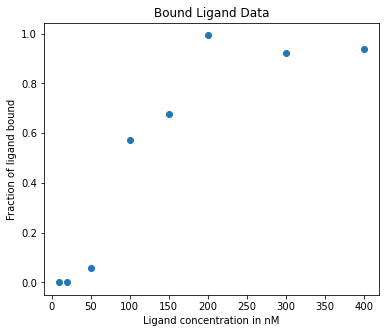

In [71]:
L = [10,20,50,100,150,200,300,400]

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(L, f_bound)
ax.set_xlabel('Ligand concentration in nM')
ax.set_ylabel('Fraction of ligand bound')
ax.set_title('Bound Ligand Data')
plt.show()

To fit a Hill equation curve to this data, we should first define a function for the Hill equation.

**Complete the function below.**

## Student Input Cell

In [50]:
def hill_eq(x,Ka,n):

    f = (x**n) / ((Ka**n) + (x**n))
    
    return f

Now that you have a function, and data to fit to it, we can use the `curve_fit` function you imported earlier. The default algorithm for this function is gradient descent. The standard syntax is:

`params, pcov = curve_fit(function,x,y,p0=[])`

Input:

1. function: This is the function you are trying to fit the data to. The first argument of this function should be the data, followed by the parameters you are trying to fit, i.e. ` function(x,p0, p1, ...)`. You'll notice we used the correct format when we defined the Hill equation function above.
2. x: These are the independent variables.
3. y: These are the observed dependent variables.
4. p0: These are your initial guesses for what the parameters might be. The order in which you enter them into this array should match the order in which they are called in the function.

Output:

1. params: These are the best fit parameters, in the order in which they are called in the function.
2. pcov: The estimated covariance of params. You can use this to determine the estimated error of the parameter estimations by using the following code: `perr = np.sqrt(np.diag(pcov))`.

**Do the following.**

1. Use the curve fitting tool to estimate Ka & n for the imported data. Use the plot to make initial guesses for what Ka & n might be.
2. Plot a continuous version of your predicted Hill equation from L = 0-> 400.
3. Plot the original data on this plot. Does the prediction look correct?

## Student Input Cell

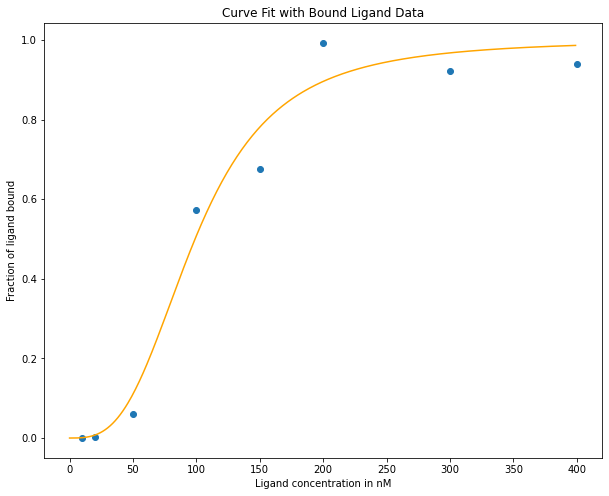

In [75]:
# Guessing that Ka=100nM and n=3
params, pcov = curve_fit(hill_eq, L, f_bound, p0=[100, 3])

x = np.arange(0, 400, 1)
y = hill_eq(x, params[0], params[1])

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(x, y, color='orange')
ax.scatter(L, f_bound)

ax.set_xlabel('Ligand concentration in nM')
ax.set_ylabel('Fraction of ligand bound')
ax.set_title('Curve Fit with Bound Ligand Data')
plt.show()